#Import Libraries

In [ ]:
!pip install statsmodels -U

In [ ]:
!pip install prophet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from itertools import product
from prophet import Prophet

#Import Data

In [ ]:
df = pd.read_csv('^SET.BK.csv')

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,1759.609985,1803.930054,1758.069946,1795.449951,1795.449951,38518400
1,2018-01-08,1799.589966,1816.810059,1784.750000,1810.189941,1810.189941,61742600
2,2018-01-15,1819.239990,1837.920044,1803.550049,1821.339966,1821.339966,59683700
3,2018-01-22,1819.140015,1848.069946,1806.130005,1828.880005,1828.880005,61856200
4,2018-01-29,1835.900024,1841.939941,1819.500000,1827.349976,1827.349976,53671800
...,...,...,...,...,...,...,...
287,2023-07-03,1507.650024,1520.020020,1474.939941,1490.510010,1490.510010,13600700
288,2023-07-10,1493.209961,1519.079956,1482.209961,1517.920044,1517.920044,14395400
289,2023-07-17,1521.390015,1545.699951,1515.449951,1529.250000,1529.250000,18954300
290,2023-07-24,1529.410034,1546.270020,1519.280029,1543.270020,1543.270020,12849100


In [ ]:
df_uni = df[['Date','Close']]

In [ ]:
df_uni

,Date,Close
0,2018-01-01,1795.449951
1,2018-01-08,1810.189941
2,2018-01-15,1821.339966
3,2018-01-22,1828.880005
4,2018-01-29,1827.349976
...,...,...
287,2023-07-03,1490.510010
288,2023-07-10,1517.920044
289,2023-07-17,1529.250000
290,2023-07-24,1543.270020


#Data Preparation

In [ ]:
df_uni.isna().sum()

Date     0
Close    0
dtype: int64

<Axes: >

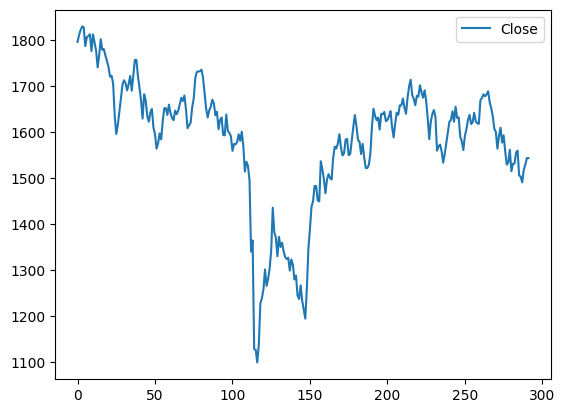

In [ ]:
df_uni.plot()

In [ ]:
import statsmodels.api as sm

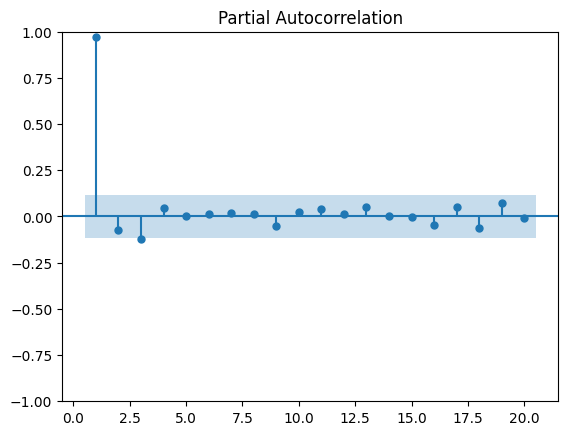

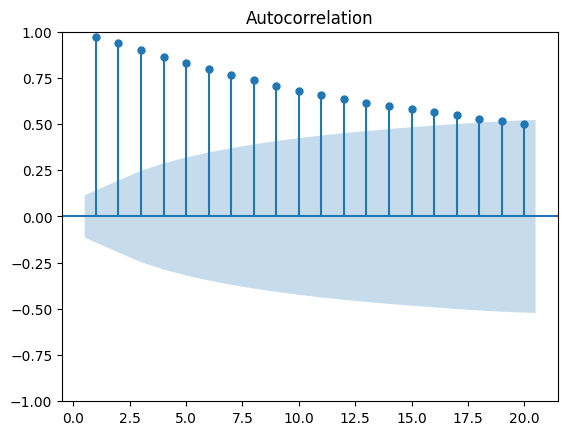

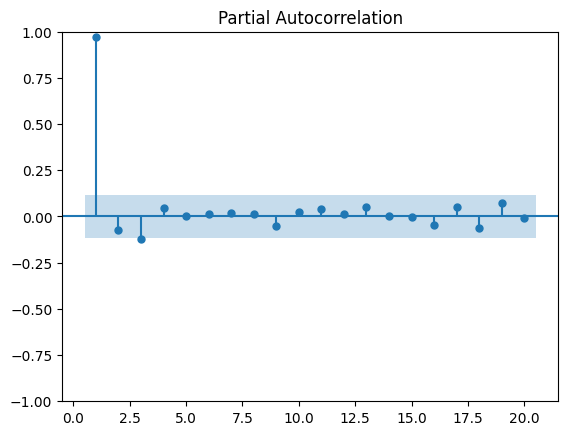

In [ ]:
sm.tsa.graphics.plot_acf(df_uni.set_index('Date'), lags=20, zero=False)
sm.tsa.graphics.plot_pacf(df_uni.set_index('Date'), lags=20, zero = False)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
mul_decom = seasonal_decompose(x=df_uni.set_index('Date'), model='multiplicative', period=13)
mul_trend = mul_decom.trend
mul_seasonal = mul_decom.seasonal
mul_residual = mul_decom.resid

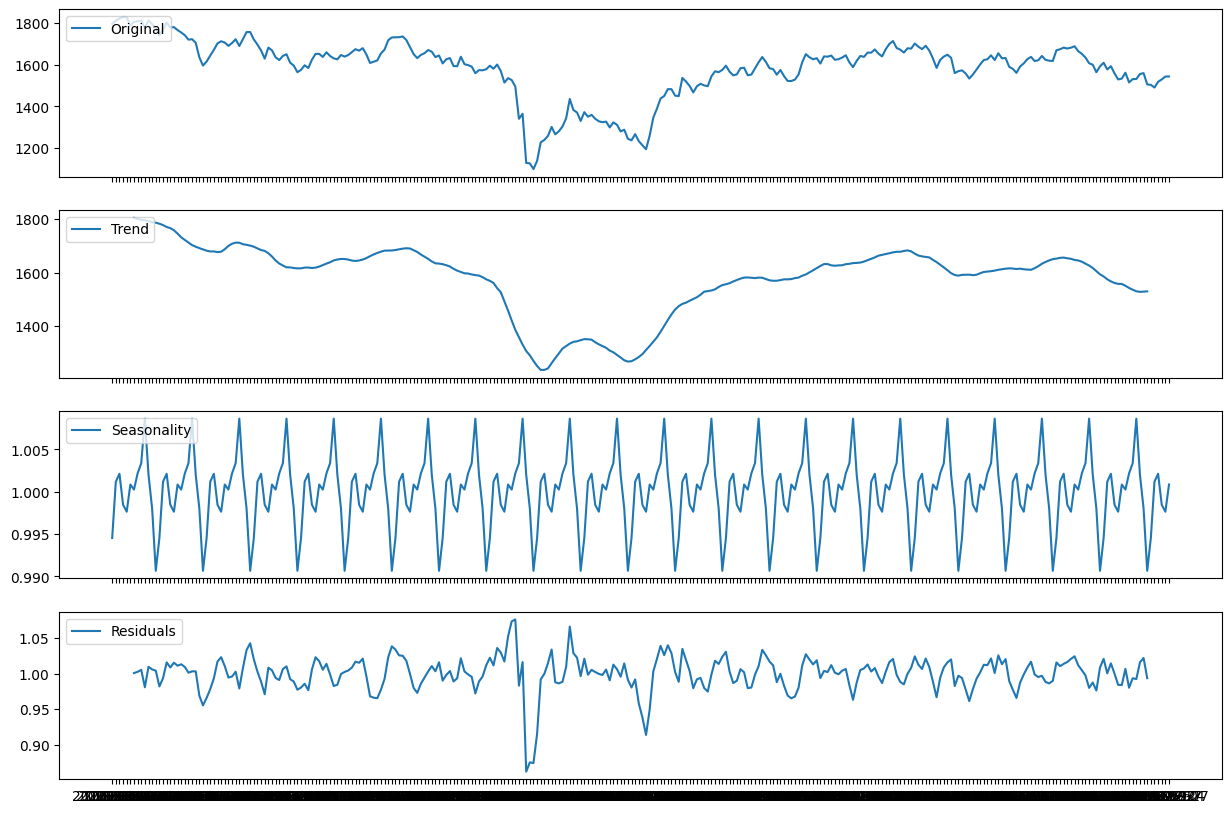

In [ ]:
fig, ax = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

ax[0].plot(df_uni.set_index('Date'), label='Original')
ax[0].legend(loc='upper left');

ax[1].plot(mul_trend, label='Trend')
ax[1].legend(loc='upper left');

ax[2].plot(mul_seasonal, label='Seasonality')
ax[2].legend(loc='upper left');

ax[3].plot(mul_residual, label='Residuals')
ax[3].legend(loc='upper left');

#Train Model

##ARIMA

In [ ]:
df_arima = df_uni.set_index('Date')

In [ ]:
df_train = df_arima.loc['2018':'2022']
df_test = df_arima.loc['2023':]

In [ ]:
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

best_score, best_params = float('inf'), None

for p, d, q in product(p_values, d_values, q_values):
    try:
        arima = ARIMA(df_train, order=(p, d, q))
        arima_fit = arima.fit()

        y_pred = arima_fit.forecast(steps=len(df_test))

        mape = mean_absolute_percentage_error(df_test, y_pred)

        if mape < best_score:
            best_score, best_params = mape, (p, d, q)

    except:
        continue

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  

In [ ]:
print("Best ARIMA Model Parameters:", best_params)
print("Best MAPE on Validation Set:", best_score)

Best ARIMA Model Parameters: None
Best MAPE on Validation Set: inf


In [ ]:
best_arima = ARIMA(df_arima, order=best_params)
best_arima_fit = best_arima.fit()
best_arima_fit.summary()

In [ ]:
plt.plot(best_arima_fit.fittedvalues, label='fitted')
plt.plot(df_arima, label='actual')
plt.legend()
plt.show()

In [ ]:
future_fcst = best_arima_fit.get_forecast(23)
confidence_int = future_fcst.conf_int(alpha = 0.1)
fcst = future_fcst.predicted_mean

plt.figure(figsize = (20, 5))
plt.title('Prediction of the SET Index using the ARIMA')
plt.plot(df_arima)
plt.plot(fcst, label = 'forcast')
plt.fill_between(confidence_int.index,confidence_int['lower Close'],confidence_int['upper Close'],alpha = 0.5)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

##SARIMAX

In [ ]:
from itertools import product

# Define the range of hyperparameters to search through
p_values = range(0, 2)  # AR(p) order (up to 2 lags)
d_values = range(0, 2)  # differencing order (up to 1)
q_values = range(0, 2)  # MA(q) order (up to 2 lags)
P_values = range(0, 2)  # seasonal AR(P) order (up to 1 seasonal lag)
D_values = range(0, 2)  # seasonal differencing order (up to 1)
Q_values = range(0, 2)  # seasonal MA(Q) order (up to 1 seasonal lag)
s_values = [13]  # seasonal period (e.g., 7 for weekly seasonality)

# Create a list of all possible combinations of hyperparameters
param_combinations = list(product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

best_aic = float("inf")
best_order = None
best_seasonal_order = None

# Iterate through all combinations and find the best model based on AIC
for order in param_combinations:
    try:
        sarima_model = sm.tsa.SARIMAX(df_train, order=order[:3], seasonal_order=order[3:])
        results = sarima_model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order[:3]
            best_seasonal_order = order[3:]
    except:
        continue

# Fit the best model on the data
best_model = sm.tsa.SARIMAX(df_arima, order=best_order, seasonal_order=best_seasonal_order)
best_sarima_model = best_model.fit()

print("Best SARIMA Model:")
print("Order:", best_order)
print("Seasonal Order:", best_seasonal_order)
print("AIC:", best_sarima_model.aic)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  

Best SARIMA Model:
Order: (0, 1, 0)
Seasonal Order: (0, 1, 1, 13)
AIC: 2751.914424247711


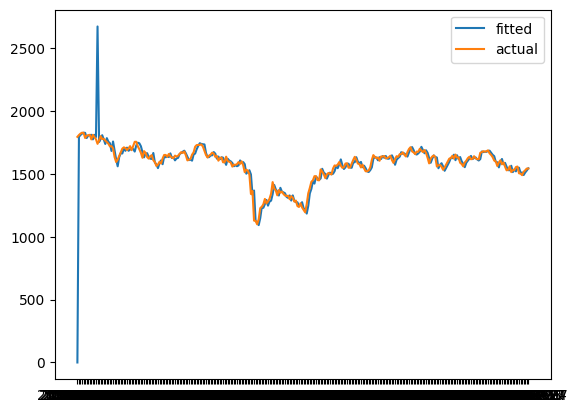

In [ ]:
plt.plot(best_sarima_model.fittedvalues, label = 'fitted')
plt.plot(df_arima, label = 'actual')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


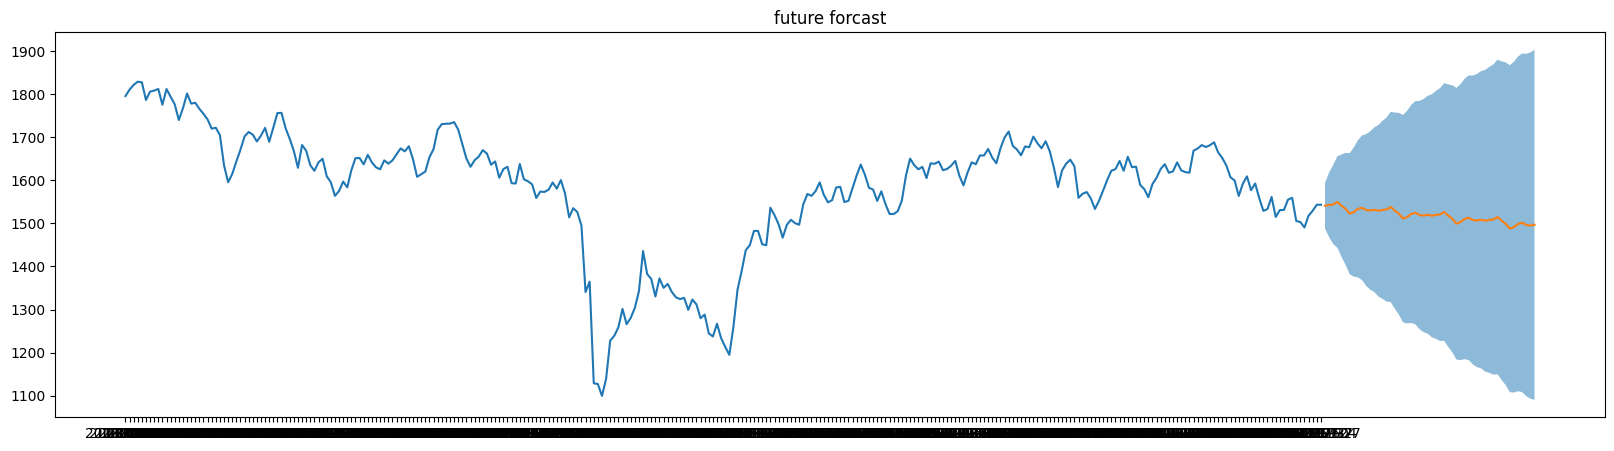

In [ ]:
future_fcst = best_sarima_model.get_forecast(steps=52)
confidence_int = future_fcst.conf_int(alpha = 0.1)
fcst = future_fcst.predicted_mean

plt.figure(figsize = (20, 5))
plt.title('future forcast')
plt.plot(df_arima)
plt.plot(fcst, label = 'future forcast')
plt.fill_between(confidence_int.index,confidence_int['lower Close'],confidence_int['upper Close'],alpha = 0.5)
plt.show()

##Prophet

In [ ]:
df_prophet = df_uni
df_prophet.columns = (['ds','y'])

In [ ]:
prophet = Prophet(daily_seasonality = True)
prophet.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpq_onwi3h/ci9f1p0a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq_onwi3h/fezfasig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89323', 'data', 'file=/tmp/tmpq_onwi3h/ci9f1p0a.json', 'init=/tmp/tmpq_onwi3h/fezfasig.json', 'output', 'file=/tmp/tmpq_onwi3h/prophet_modeliio_9vyb/prophet_model-20230728214634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:46:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:46:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = prophet.make_future_dataframe(periods=23, freq='W')
forecast = prophet.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds         yhat   yhat_lower   yhat_upper
310 2023-12-03  1558.173218  1480.276284  1638.793858
311 2023-12-10  1554.567339  1475.955520  1635.048197
312 2023-12-17  1554.047645  1467.700805  1638.927815
313 2023-12-24  1560.575422  1477.995818  1641.207755
314 2023-12-31  1572.123039  1487.366436  1655.276682


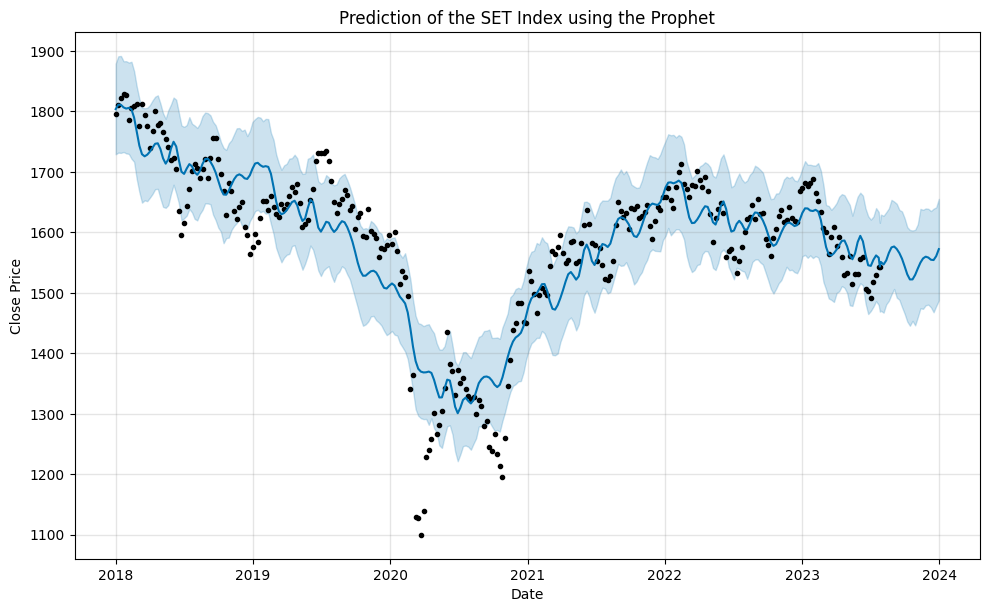

In [ ]:
prophet.plot(forecast)
plt.title('Prediction of the SET Index using the Prophet')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

##LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
df_lstm = df.set_index('Date')
y = df_lstm['Close']
features = ['Open', 'High', 'Low', 'Volume']
X = df_lstm[features]

In [ ]:
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X_scale = pd.DataFrame(columns=features, data=X_scale, index=y.index)
X_scale.head()

,Open,High,Low,Volume
Date,,,,
2018-01-01,0.903461,0.933290,0.927765,0.347674
2018-01-08,0.954052,0.950977,0.959138,0.557300
2018-01-15,0.978918,0.979965,0.981245,0.538716
2018-01-22,0.978792,0.993903,0.984278,0.558325
2018-01-29,1.000000,0.985485,1.000000,0.484451


In [ ]:
y_train, y_test = y.loc['2018':'2022'], y.loc['2023':]
X_train, X_test = X_scale.loc['2018':'2022'], X_scale.loc['2023':]

In [ ]:
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
lstm = Sequential()
lstm.add(LSTM(64, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_absolute_percentage_error', optimizer='adam')
lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                17664     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = lstm.fit(X_train, y_train, epochs=500, batch_size=128, verbose=1, shuffle=False)

Epoch 1/500
2/2 [==============================] - 2s 8ms/step - loss: 99.9991
Epoch 2/500
2/2 [==============================] - 0s 7ms/step - loss: 99.9983
Epoch 3/500
2/2 [==============================] - 0s 9ms/step - loss: 99.9976
Epoch 4/500
2/2 [==============================] - 0s 7ms/step - loss: 99.9969
Epoch 5/500
2/2 [==============================] - 0s 8ms/step - loss: 99.9962
Epoch 6/500
2/2 [==============================] - 0s 7ms/step - loss: 99.9955
Epoch 7/500
2/2 [==============================] - 0s 7ms/step - loss: 99.9948
Epoch 8/500
2/2 [==============================] - 0s 7ms/step - loss: 99.9941
Epoch 9/500
2/2 [==============================] - 0s 7ms/step - loss: 99.9934
Epoch 10/500
2/2 [==============================] - 0s 7ms/step - loss: 99.9927
Epoch 11/500
2/2 [==============================] - 0s 7ms/step - loss: 99.9920
Epoch 12/500
2/2 [==============================] - 0s 7ms/step - loss: 99.9913
Epoch 13/500
2/2 [==============================]

In [ ]:
y_pred= lstm.predict(X_test)

1/1 [==============================] - 0s 399ms/step


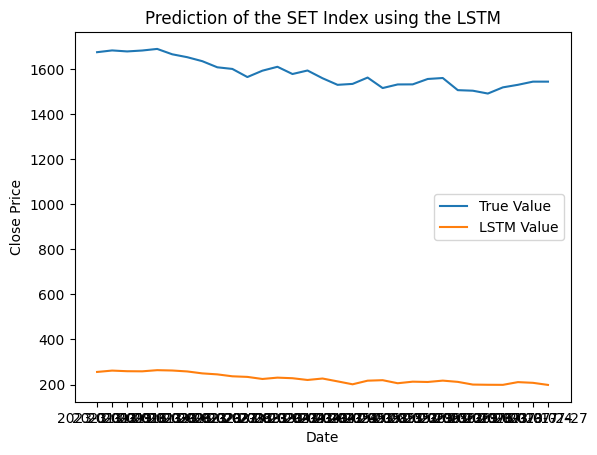

In [ ]:
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction of the SET Index using the LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()